# How to detect semantic similarity between two Entities 

The challenge consists of a dataset in csv format which contains 2 entities in form of company name and a tag stating if they are similar entities or different. Company names from different data sources don’t always match because of different word orders / spaces & special characters / abbreviations / typos / changes in company type (GmbH -> AG) / prefixes and suffixes, etc. 
### The task 
1. Return probablity of entities being same. 
2. Should not be based on Rule methods
3. Explore accuracies 
4. Discuss deployment techniques in brief

### ***SOLUTION***: We take the following steps to discuss this in detail. 
1.   Import data
2.   Explore data - Texts, Distribution etc. 
3.   Model to return probabilities 
4.   How do we measure similarity ? thresholds, to prove entity similarity? 
5.   Discuss accuracies and F1 scores 
6.   Methods to deploy 
7.   Conclusion, Improvements and other methods 

### 1. Import data 



Using pandas to read a dataset consisting of 4 columns 
1. Index
2. Entity 1 
3. Entity 2
4. Label (Tag) 1=similar 0=different

In [ ]:
import pandas as pd

df_full =pd.read_csv("drive/My Drive/alpas_data/ds_challenge_alpas.csv")
df_full.head()

,Unnamed: 0,entity_1,entity_2,tag
0,3137667,preciform A.B,Preciform AB,1
1,5515816,degener staplertechnik vertriebs-gmbh,Irshim,0
2,215797,Alltel South CaroliNA Inc,alltel south carolina INC.,1
3,1004621,cse Corporation,Cse Corp,1
4,1698689,Gruppo D Motors Srl,gruppo d motors Sociedad de Resposabilidad Lim...,1


### 2. Explore data 

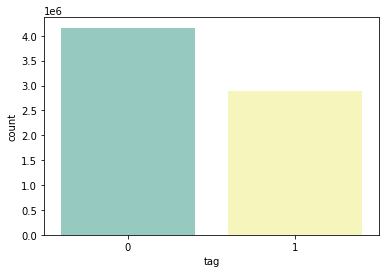

In [ ]:
# importing the required library
 
import seaborn as sns
import matplotlib.pyplot as plt
# count plot on single categorical variable
sns.countplot(x ='tag', data = df_full, palette="Set3")

# Show the plot
plt.show()

The plan is to use transformer model and due to limitation of my personal computer (lacking GPU) capacities I am unable to process huge number of rows while using transformer model. (I have tried, but due to high RAM requirement it was difficult to continue) Therefore an alternative is to take a random sub-sample of the dataset. 

Why Random sun-sample?  in order to retain the ratio of the number of rows we need to do the sampling accordingly. We consider replace as false as we do not want same rows to be repeated in our sub-sample. Random state defines that we are able to re-produce the same sub-sample again with the number 42. 

In [ ]:
df = df_full.sample(frac=0.001, replace=False, random_state=42)

In [ ]:
# checking number of rows and columns 
df.shape 

(7043, 4)

In [ ]:
df.head(5)

,Unnamed: 0,entity_1,entity_2,tag,prob_scores,pred
2350671,490836,batliboi LIMITED,Batliboi Ltd,1,0.806285,1
4734450,1366944,exascaler inc,ExaScaler Inc,1,1.000000,1
1221001,1602054,general industries Inc.,General Industries Inc,1,0.986246,1
3733399,2336638,landers auto group INC.,Landers Auto Group Inc,1,0.985621,1
6917916,8552150,wircon gmbh,fonderia augusta,0,0.148863,0


Here we have a labeled data where Tag column represents whether the two entities are similar or not similar. Some examples of entities are 
1. batliboi LIMITED	and Batliboi Ltd which has a tag of 1 and we clearly see that ltd and LIMITED mean the same as per Human interpretation however, it is not a very intuitive process to a machine. 
2. Whereas, wircon gmbh and fonderia augusta are clearly two different company names. 

*We see that our sub-sampling technique has retained the ratio or Tag0 and Tag 1 correctly. 

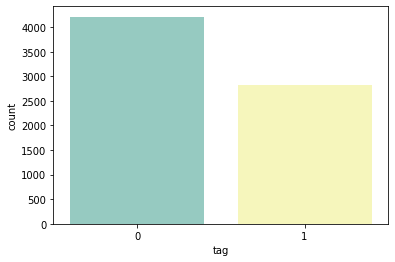

In [ ]:
# importing the required library
 
import seaborn as sns
import matplotlib.pyplot as plt
# count plot on single categorical variable
sns.countplot(x ='tag', data = df, palette="Set3")

# Show the plot
plt.show()

Data distribution shows that we have more labeled data for companies that are different than the companies that are same. The ratio seems to be approximately 2/3. Something to be noted while developing a solution using supervised learning methods. 

### 3.   Model to return probabilities 

In this notebook we design a solution using sentence transformer models. 
Due to time constrain I decided to provide end to end solution of only 1 model and how it would looks like, the conclusion part will explore other possible solutions. 
 

#### Why sentence transformer model ?
1. It is state of the art 

2. It will capture the entire entity into one single context making it more efficient and accurate.  

*For example : Gruppo D Motors Srl and gruppo d motors Sociedad de Resposabilidad Limited. Consider these two entities, the first entity consists of 4 words which will be 4 tokens (considering NLP) and the 2nd entity consists of 7 words i.e. 7 tokens. However, they are refering to the same company and have a tag of 1. Therefore, our algorithm needs to capture the entire context of all the words and then decide on their probalities.*

3. Concentrate on semantic similarity of the word rather than syntactic similarity. 

ltd vs LIMITED, syntactically they are 2 different words but semantically they have very similar meaning. Therefore, our algorithm should assign them very similar probabilities to be accurate. 

In [ ]:
# pip install sentence-transformer 
!pip install sentence-transformers

In [ ]:
# import transformer model 
from sentence_transformers import SentenceTransformer, util

In [ ]:
# We explore and use sentence transformer model all-MiniLM-L6-v2 here 
model = SentenceTransformer('all-MiniLM-L6-v2')

The model details can be found her : https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 

Taking a small example to explain how the model works. We take the given 3 entities here, 2 are same 1 is different. 

In [ ]:
ent_1 = ['preciform A.B',
          'degener staplertechnik vertriebs-gmbh',
          'Alltel South CaroliNA Inc']

ent_2 = ['Preciform AB',
           'Irshim',
          'alltel south carolina INC.']

In [ ]:
print(type(ent_1))

<class 'list'>


We use the pre-trained ***all-MiniLM-L6-v2*** to create contextualized word embedding using the model for our companies. 

em_1 creates embeddings for entities in list 1 and em_2 creates embedding for entities in list 2. 

In [ ]:
em_1 = model.encode(ent_1)
em_2 = model.encode(ent_2)

Based on the embedding created from our model we now see what is the cosine distance between the two entities. Why cosine distance ? We use cosine distance in this example as it is one of the popular ways to measure distance between two vectors/datapoints. It is given by the following formula: 

`Cos(x, y) = x . y / ||x|| * ||y||`

Here is a blog that define more on similarity calculation : https://www.geeksforgeeks.org/cosine-similarity/ 

Other popular measures are Euclidean, Manhattan, Jaccard etc. but we go ahead with cosine for this problem. 

In [ ]:
# compare cosine similarity between em_1 and em_2 that is entity1 and entity2 
cosine_scores = util.cos_sim(em_1, em_2)
print(type(cosine_scores))
print(cosine_scores)

<class 'torch.Tensor'>
tensor([[0.7796, 0.0341, 0.1603],
        [0.1855, 0.1346, 0.3083],
        [0.1986, 0.1503, 0.9893]])


We see in the above result that is gives us a list of probablities if the two entities are similar. 

In [ ]:
for i in range(len(ent_1)):
    result = cosine_scores[i][i].item()
    print("sent_1: ", ent_1[i])
    print("sent_2: ", ent_2[i])
    print("result: ", result)
    print("----------------------------------")

sent_1:  preciform A.B
sent_2:  Preciform AB
result:  0.7795949578285217
----------------------------------
sent_1:  degener staplertechnik vertriebs-gmbh
sent_2:  Irshim
result:  0.13464169204235077
----------------------------------
sent_1:  Alltel South CaroliNA Inc
sent_2:  alltel south carolina INC.
result:  0.9892873167991638
----------------------------------


Here we see the preciform A.B is three words and Preciform AB is 2 words also with capital and small letters, even then the model is successfully able to predict that the 2 entites are similar with the confidence/probablity of 0.779. 
Same with entity 3 Alltel South CaroliNA Inc. 
But we want to do this on a large scale so we explore how to do that below. We do exactly the same steps but now we perform this on the whole dataframe. 

In [ ]:
lst_entity_1 = df['entity_1'].to_list()
lst_entity_2 = df['entity_2'].to_list()

In [ ]:
print(lst_entity_2[0], lst_entity_1[0])

Batliboi Ltd batliboi LIMITED


In [ ]:
print(len(lst_entity_1),len(lst_entity_2))

7043 7043


In [ ]:
encode_1 = model.encode(lst_entity_1)
encode_2 = model.encode(lst_entity_2)

In [ ]:
cosine_scores = util.cos_sim(encode_1, encode_2)
print(type(cosine_scores))

<class 'torch.Tensor'>


In [ ]:
cosine_scores.shape

torch.Size([7043, 7043])

In [ ]:
results = []

In [ ]:
for i in range(len(lst_entity_1)):
    results.append(cosine_scores[i][i].item())

In [ ]:
print(type(results), len(results))

<class 'list'> 7043


In [ ]:
# add the probabilities to the existing dataframe as additional column 
df['prob_scores'] = results

We have added a column called prob_scores that represent the probabilties of each row (entity1 and entity2 being same or different) using method explained above. 

In [ ]:
df.head()

,Unnamed: 0,entity_1,entity_2,tag,prob_scores
2350671,490836,batliboi LIMITED,Batliboi Ltd,1,0.806285
4734450,1366944,exascaler inc,ExaScaler Inc,1,1.000000
1221001,1602054,general industries Inc.,General Industries Inc,1,0.986246
3733399,2336638,landers auto group INC.,Landers Auto Group Inc,1,0.985621
6917916,8552150,wircon gmbh,fonderia augusta,0,0.148863


### 4.   How do we measure similarity ? thresholds, to prove entity similarity? 

Now the question is, we have a probabilty score but how to we define based on this probablity score if the entities are similar or not? 
This is also a problem that can be explored further to compare and to see difference why certain probalities might have been asgined to different entities. 

Given the time constrain for developing the solution for this problem we decide to go ahead with the threshold score of 0.7. 
Therefore, if the probability score is above 0.7 then it is safe to say that both the entities are same and if they are below this threshold then the entities are different. 

In [ ]:
import numpy as np

We define a pred column based on our threshold values discussed above. 

In [ ]:
df['pred'] = np.where(df['prob_scores']>= 0.7, 1,0)

In [ ]:
df.head()

,Unnamed: 0,entity_1,entity_2,tag,prob_scores,pred
2350671,490836,batliboi LIMITED,Batliboi Ltd,1,0.806285,1
4734450,1366944,exascaler inc,ExaScaler Inc,1,1.000000,1
1221001,1602054,general industries Inc.,General Industries Inc,1,0.986246,1
3733399,2336638,landers auto group INC.,Landers Auto Group Inc,1,0.985621,1
6917916,8552150,wircon gmbh,fonderia augusta,0,0.148863,0


In [ ]:
y_true = df['tag'].to_list()
y_pred = df['pred'].to_list()

### 5.   Discuss accuracies and F1 scores 

We already have a labeled dataset and know if the entities are similar or not, so now we compare our model performance using the probablity score and prediction variable (based on 0.7 threshold) and actual labels for the entities. 


y_true is our true label or tag column and 


y_pred (predicted) is the label from our model (+ threshold 0.7)

In [ ]:
# import confusion_matrix from sklearn python library 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)

Out of the 7043 samples that we shortlisted based on random sampling method 4211 rows consisted of tag 0 (different) and 2832 row consisted of tag 1 (same entities). 
Our model was able to acheive a 0.97% f1-score to predict whether the entities are same or different. We consider f1-score here instead of accuracy as also considers the false positive and well as false negatives into consideration. 


**Recall: TP / TP+FN**


**Precision: TP / TP+FP**


**F1 = 2 * ((Precision*Recall) /Precision + Recall))**

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Label/Tag 0: Different Entity', 'Label/Tag 1:Same Entity']
print(classification_report(y_true, y_pred, target_names=target_names))

                               precision    recall  f1-score   support

Label/Tag 0: Different Entity       0.95      1.00      0.98      4211
      Label/Tag 1:Same Entity       1.00      0.93      0.96      2832

                     accuracy                           0.97      7043
                    macro avg       0.98      0.96      0.97      7043
                 weighted avg       0.97      0.97      0.97      7043



Let us see the confusion matrix. Our model was able to classify all the Tag 0 entities (or mismatch entities) with a wooping 98% f1-score. 
And Tag 1 (same entities) only 199 out of 2832 were mis-classified. That is a f1-score of 96%
The weighted avg comes to around 97% 

Feel free to go about the visulation of confusion matrix below. 

In [ ]:
print(cf_matrix)

[[4211    0]
 [ 199 2633]]


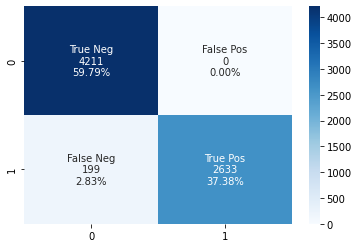

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 6.   Methods to deploy 

The models from the Huggingface library can be deployed, easily using an API on most of the popular cloud service/ micro service providers such as GCP, AWS or Azure. 
Here is a blog from Huggingface platform which provides a detailed explaination: 
https://huggingface.co/blog/how-to-deploy-a-pipeline-to-google-clouds


### 7.   Conclusion, Improvements and other methods 

### Conclusion: 
We can conclude saying that our hypothesis of using a sentence transformer model has worked well. An f1-score of 97% was able to be acheived using this technique to identify the correct entities by a semantic method rather than just relying on their syntax. 

### Limitations and other methods 
This notebook explores only 1 of the possibilities to handle the solution. Other libraries that can be explore include, Spacy, Tf-idf, word2vec, Glove based embeddings. (tf-idf, word2vec,glove are older techniques) but this can be explored further if they suit the company use case better. 
I can also argue that if the older techniques provides a good enough accuracy they these can also be used into production as transformer models can be quick computationally heavy. (this was also one of the reason why only 7043 were considered for the purpose of this notebook, as I lack the computation resource to run more rows with the transformer model, when deploying in cloud service this can be scaled accordingly). 
Or in case of significant performnce difference, we can also explore other transformer based models compared to the one used in this notebook. 
There was not much logic used to define the threshold of 0.7, this can be also be a team/management decision and can be discussed further. 

Also, this notebook only discussed using transformer model directly from the Hugginface library but going further we can also explore how we can fine-tune these models specifically for our company use case.
 
